In [1]:
import os
import tempfile
import shutil
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

from medmnist import ChestMNIST
from pytorch_fid import fid_score
from skimage.metrics import structural_similarity as ssim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 100
embedding_dim = 10
num_classes = 2  # 0: non-pneumonia, 1: pneumonia
img_size = 64
img_channels = 1  # Grayscale images
batch_size = 64
num_epochs = 400    # Maximum number of epochs; you can extend this as needed
lr = 0.0004
step_size = 25     # Every 50 epochs, the LR will be decayed
gamma = 0.99        # Decay factor for LR

Using device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.block(x)
        out += x  # Skip connection
        return self.relu(out)


In [4]:
class GeneratorIncreasedChannels(nn.Module):
    def __init__(self, latent_dim, embedding_dim, num_classes, img_channels, img_size):
        super(GeneratorIncreasedChannels, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        # Keep the same scaling factor: downsampled size will be img_size//4
        self.init_size = img_size // 4  
        # Increase the number of channels in the first fully connected layer to 256 instead of 128
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 256 * self.init_size * self.init_size)
        )
        
        # Initial upsampling block – now working with 256 channels
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),  # Upsample from init_size to init_size*2
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(inplace=True)
        )
        
        # Add a couple of Residual Blocks; these work on 256 channels
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256)
        )
        
        # Final blocks: upsample and reduce channels to produce the final image
        self.final_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # Upsample to full image resolution
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Tanh activation yields outputs in [-1, 1]
        )
        
    def forward(self, noise, labels):
        # Embed the labels
        label_input = self.label_embedding(labels)
        # Concatenate noise and label embedding along the last dimension
        gen_input = torch.cat((noise, label_input), dim=-1)
        out = self.fc(gen_input)
        # Reshape to a feature map of shape (batch, 256, init_size, init_size)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        out = self.conv_blocks(out)
        out = self.residual_blocks(out)
        img = self.final_blocks(out)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes, img_size, embedding_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        ds_size = img_size // 2**4  # after 4 downsampling steps
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels)
        # Expand label embedding to match image spatial size
        label_map = label_embedding.unsqueeze(2).unsqueeze(3)
        label_map = label_map.repeat(1, 1, img.size(2), img.size(3))
        label_map = label_map.mean(dim=1, keepdim=True)  # average to get one channel
        d_in = torch.cat((img, label_map), 1)
        out = self.model(d_in)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [6]:
generator = GeneratorIncreasedChannels(latent_dim, embedding_dim, num_classes, img_channels, img_size).to(device)
discriminator = Discriminator(img_channels, num_classes, img_size, embedding_dim).to(device)
print(generator)
print(discriminator)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=step_size, gamma=gamma)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=step_size, gamma=gamma)

GeneratorIncreasedChannels(
  (label_embedding): Embedding(2, 10)
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=65536, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    

In [8]:
from torchvision.transforms.functional import hflip, to_tensor
from torch.utils.data import Dataset, ConcatDataset
import torch
from medmnist import ChestMNIST

class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, label_index=6, flip=False):
        self.base_dataset = base_dataset
        self.label_index = label_index
        self.flip = flip
        self.indices = [i for i in range(len(base_dataset)) if int(base_dataset[i][1][label_index]) == 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.base_dataset[real_idx]  # img is PIL.Image

        img = to_tensor(img)  # Now it's a tensor in [0, 1], shape (1, 64, 64)

        if self.flip:
            img = hflip(img)

        img = img * 2 - 1  # Normalize to [-1, 1]
        return img, 1  # dummy label

    
full_dataset = ChestMNIST(split='train', transform=None, download=True,size=64)
pneumonia_original = PneumoniaDataset(full_dataset, flip=False)
pneumonia_flipped = PneumoniaDataset(full_dataset, flip=True)

augmented_dataset = ConcatDataset([pneumonia_original, pneumonia_flipped])
pneumonia_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


In [9]:
def sample_real_images(loader, num_samples=100):
    imgs_list = []
    count = 0
    for imgs, _ in loader:
        imgs_list.append(imgs)
        count += imgs.size(0)
        if count >= num_samples:
            break
    imgs = torch.cat(imgs_list, dim=0)[:num_samples]
    imgs = (imgs + 1) / 2  # Convert from [-1,1] to [0,1]
    return imgs

fixed_real = sample_real_images(pneumonia_loader, num_samples=100)

In [10]:
def save_images_to_folder(images, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i in range(images.size(0)):
        img = images[i]
        save_path = os.path.join(folder, f"{prefix}_{i}.png")
        utils.save_image(img, save_path)

def compute_batch_ssim(real_imgs, fake_imgs):
    # Assume real_imgs and fake_imgs are numpy arrays of shape (N, 1, H, W)
    real_imgs = real_imgs.squeeze(1)
    fake_imgs = fake_imgs.squeeze(1)
    ssim_vals = []
    for i in range(real_imgs.shape[0]):
        s = ssim(real_imgs[i], fake_imgs[i], data_range=1.0)
        ssim_vals.append(s)
    return np.mean(ssim_vals)

In [11]:
temp_real_dir = tempfile.mkdtemp()
temp_fake_dir = tempfile.mkdtemp()

In [12]:
best_fid = float('inf')
best_epoch = 0

print("Starting GAN training with Learning Rate Scheduler...")
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for i, (imgs, _) in enumerate(pneumonia_loader):
        current_batch = imgs.size(0)
        valid = torch.ones(current_batch, 1, device=device)
        fake_label = torch.zeros(current_batch, 1, device=device)
        
        real_imgs = imgs.to(device)
        labels = torch.ones(current_batch, dtype=torch.long, device=device)
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(current_batch, latent_dim, device=device)
        gen_labels = torch.ones(current_batch, dtype=torch.long, device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(pneumonia_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Step the schedulers
    scheduler_G.step()
    scheduler_D.step()
    
    # Evaluate after each epoch
    generator.eval()
    with torch.no_grad():
        z = torch.randn(100, latent_dim, device=device)
        gen_labels = torch.ones(100, dtype=torch.long, device=device)
        fake_imgs = generator(z, gen_labels)
    fake_imgs = (fake_imgs + 1) / 2  # Convert to [0,1]
    
    # Clear temporary directories
    for f in os.listdir(temp_real_dir):
        os.remove(os.path.join(temp_real_dir, f))
    for f in os.listdir(temp_fake_dir):
        os.remove(os.path.join(temp_fake_dir, f))
    save_images_to_folder(fixed_real, temp_real_dir, "real")
    save_images_to_folder(fake_imgs, temp_fake_dir, "fake")
    
    current_fid = fid_score.calculate_fid_given_paths([temp_real_dir, temp_fake_dir],
                                                       batch_size, device, dims=2048)
    fixed_real_np = fixed_real.cpu().numpy()
    fake_imgs_np = fake_imgs.cpu().numpy()
    current_ssim = compute_batch_ssim(fixed_real_np, fake_imgs_np)
    
    print(f"Epoch {epoch} -- FID: {current_fid:.3f}, SSIM: {current_ssim:.3f}")
    
    # Save best generator checkpoint based on FID (lower is better)
    if current_fid < best_fid:
        best_fid = current_fid
        best_epoch = epoch
        torch.save(generator.state_dict(), "best_rlrgenerator.pth")
        print(f"New best model found at epoch {epoch} with FID: {current_fid:.3f}")
    
print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")

100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 334 -- FID: 129.107, SSIM: 0.337
[Epoch 335/400] [Batch 0/31] [D loss: 0.3738] [G loss: 2.9280]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 335 -- FID: 136.225, SSIM: 0.349
[Epoch 336/400] [Batch 0/31] [D loss: 0.4182] [G loss: 1.9001]


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 336 -- FID: 142.852, SSIM: 0.308
[Epoch 337/400] [Batch 0/31] [D loss: 0.3306] [G loss: 2.0842]


100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Epoch 337 -- FID: 135.171, SSIM: 0.342
[Epoch 338/400] [Batch 0/31] [D loss: 0.2908] [G loss: 2.1922]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 338 -- FID: 137.164, SSIM: 0.315
[Epoch 339/400] [Batch 0/31] [D loss: 0.3871] [G loss: 1.8491]


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 339 -- FID: 154.844, SSIM: 0.347
[Epoch 340/400] [Batch 0/31] [D loss: 0.2349] [G loss: 2.1307]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 340 -- FID: 135.463, SSIM: 0.339
[Epoch 341/400] [Batch 0/31] [D loss: 0.2945] [G loss: 2.0550]


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 341 -- FID: 141.358, SSIM: 0.340
[Epoch 342/400] [Batch 0/31] [D loss: 0.3058] [G loss: 2.2793]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 342 -- FID: 140.070, SSIM: 0.308
[Epoch 343/400] [Batch 0/31] [D loss: 0.2932] [G loss: 2.3360]


100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Epoch 343 -- FID: 139.863, SSIM: 0.323
[Epoch 344/400] [Batch 0/31] [D loss: 0.3346] [G loss: 2.1958]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 344 -- FID: 145.936, SSIM: 0.339
[Epoch 345/400] [Batch 0/31] [D loss: 0.3012] [G loss: 2.3894]


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Epoch 345 -- FID: 139.547, SSIM: 0.335
[Epoch 346/400] [Batch 0/31] [D loss: 0.2671] [G loss: 2.9917]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 346 -- FID: 141.727, SSIM: 0.313
[Epoch 347/400] [Batch 0/31] [D loss: 0.3567] [G loss: 1.7825]


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 347 -- FID: 141.011, SSIM: 0.355
[Epoch 348/400] [Batch 0/31] [D loss: 0.3239] [G loss: 1.6299]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 348 -- FID: 141.886, SSIM: 0.328
[Epoch 349/400] [Batch 0/31] [D loss: 0.3023] [G loss: 1.7611]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 349 -- FID: 152.906, SSIM: 0.341
[Epoch 350/400] [Batch 0/31] [D loss: 0.3128] [G loss: 1.8684]


100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Epoch 350 -- FID: 128.487, SSIM: 0.347
[Epoch 351/400] [Batch 0/31] [D loss: 0.3703] [G loss: 1.6668]


100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Epoch 351 -- FID: 159.232, SSIM: 0.345
[Epoch 352/400] [Batch 0/31] [D loss: 0.3908] [G loss: 2.3110]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 352 -- FID: 132.259, SSIM: 0.327
[Epoch 353/400] [Batch 0/31] [D loss: 0.1818] [G loss: 2.4053]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 353 -- FID: 130.865, SSIM: 0.330
[Epoch 354/400] [Batch 0/31] [D loss: 0.2638] [G loss: 2.1255]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 354 -- FID: 144.413, SSIM: 0.335
[Epoch 355/400] [Batch 0/31] [D loss: 0.3028] [G loss: 2.2834]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 355 -- FID: 157.691, SSIM: 0.352
[Epoch 356/400] [Batch 0/31] [D loss: 0.3688] [G loss: 2.3991]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 356 -- FID: 140.463, SSIM: 0.322
[Epoch 357/400] [Batch 0/31] [D loss: 0.2823] [G loss: 3.3800]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 357 -- FID: 128.918, SSIM: 0.348
[Epoch 358/400] [Batch 0/31] [D loss: 0.2292] [G loss: 3.4192]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 358 -- FID: 133.769, SSIM: 0.324
[Epoch 359/400] [Batch 0/31] [D loss: 0.2713] [G loss: 2.6663]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 359 -- FID: 143.391, SSIM: 0.320
[Epoch 360/400] [Batch 0/31] [D loss: 0.3713] [G loss: 1.8704]


100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


Epoch 360 -- FID: 137.296, SSIM: 0.332
[Epoch 361/400] [Batch 0/31] [D loss: 0.3960] [G loss: 1.8998]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 361 -- FID: 131.008, SSIM: 0.340
[Epoch 362/400] [Batch 0/31] [D loss: 0.2594] [G loss: 2.4040]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 362 -- FID: 142.001, SSIM: 0.320
[Epoch 363/400] [Batch 0/31] [D loss: 0.3931] [G loss: 2.2736]


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 363 -- FID: 143.253, SSIM: 0.335
[Epoch 364/400] [Batch 0/31] [D loss: 0.2328] [G loss: 2.1975]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 364 -- FID: 138.891, SSIM: 0.327
[Epoch 365/400] [Batch 0/31] [D loss: 0.3200] [G loss: 2.2310]


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Epoch 365 -- FID: 145.374, SSIM: 0.326
[Epoch 366/400] [Batch 0/31] [D loss: 0.2009] [G loss: 2.8346]


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Epoch 366 -- FID: 133.900, SSIM: 0.328
[Epoch 367/400] [Batch 0/31] [D loss: 0.1830] [G loss: 2.3088]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 367 -- FID: 142.265, SSIM: 0.339
[Epoch 368/400] [Batch 0/31] [D loss: 0.2311] [G loss: 2.5014]


100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


Epoch 368 -- FID: 130.236, SSIM: 0.324
[Epoch 369/400] [Batch 0/31] [D loss: 0.4249] [G loss: 2.1756]


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


Epoch 369 -- FID: 140.850, SSIM: 0.331
[Epoch 370/400] [Batch 0/31] [D loss: 0.3899] [G loss: 2.4925]


100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


Epoch 370 -- FID: 138.867, SSIM: 0.319
[Epoch 371/400] [Batch 0/31] [D loss: 0.2553] [G loss: 2.9971]


100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


Epoch 371 -- FID: 138.372, SSIM: 0.322
[Epoch 372/400] [Batch 0/31] [D loss: 0.2513] [G loss: 2.6281]


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Epoch 372 -- FID: 150.251, SSIM: 0.333
[Epoch 373/400] [Batch 0/31] [D loss: 0.2205] [G loss: 2.2627]


100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Epoch 373 -- FID: 144.713, SSIM: 0.331
[Epoch 374/400] [Batch 0/31] [D loss: 0.2362] [G loss: 2.7614]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 374 -- FID: 152.453, SSIM: 0.314
[Epoch 375/400] [Batch 0/31] [D loss: 0.2139] [G loss: 2.6115]


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch 375 -- FID: 135.805, SSIM: 0.324
[Epoch 376/400] [Batch 0/31] [D loss: 0.2101] [G loss: 2.5886]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 376 -- FID: 153.601, SSIM: 0.326
[Epoch 377/400] [Batch 0/31] [D loss: 0.2870] [G loss: 1.9942]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 377 -- FID: 138.519, SSIM: 0.329
[Epoch 378/400] [Batch 0/31] [D loss: 0.2216] [G loss: 2.2843]


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Epoch 378 -- FID: 120.651, SSIM: 0.342
New best model found at epoch 378 with FID: 120.651
[Epoch 379/400] [Batch 0/31] [D loss: 0.2387] [G loss: 2.3909]


100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Epoch 379 -- FID: 122.070, SSIM: 0.333
[Epoch 380/400] [Batch 0/31] [D loss: 0.2290] [G loss: 2.7151]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 380 -- FID: 136.975, SSIM: 0.334
[Epoch 381/400] [Batch 0/31] [D loss: 0.2202] [G loss: 2.3157]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 381 -- FID: 137.832, SSIM: 0.324
[Epoch 382/400] [Batch 0/31] [D loss: 0.2701] [G loss: 3.2840]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 382 -- FID: 128.495, SSIM: 0.329
[Epoch 383/400] [Batch 0/31] [D loss: 0.3167] [G loss: 2.4315]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 383 -- FID: 128.915, SSIM: 0.339
[Epoch 384/400] [Batch 0/31] [D loss: 0.2158] [G loss: 2.1098]


100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


Epoch 384 -- FID: 145.773, SSIM: 0.323
[Epoch 385/400] [Batch 0/31] [D loss: 0.3690] [G loss: 2.3491]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 385 -- FID: 143.751, SSIM: 0.327
[Epoch 386/400] [Batch 0/31] [D loss: 0.2303] [G loss: 2.5383]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 386 -- FID: 136.887, SSIM: 0.324
[Epoch 387/400] [Batch 0/31] [D loss: 0.2935] [G loss: 2.2224]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 387 -- FID: 133.848, SSIM: 0.319
[Epoch 388/400] [Batch 0/31] [D loss: 0.2752] [G loss: 2.3060]


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Epoch 388 -- FID: 135.826, SSIM: 0.322
[Epoch 389/400] [Batch 0/31] [D loss: 0.3448] [G loss: 2.9506]


100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Epoch 389 -- FID: 139.073, SSIM: 0.328
[Epoch 390/400] [Batch 0/31] [D loss: 0.3710] [G loss: 2.3690]


100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Epoch 390 -- FID: 143.313, SSIM: 0.338
[Epoch 391/400] [Batch 0/31] [D loss: 0.3244] [G loss: 2.4754]


100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Epoch 391 -- FID: 154.370, SSIM: 0.326
[Epoch 392/400] [Batch 0/31] [D loss: 0.3245] [G loss: 1.6300]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 392 -- FID: 132.877, SSIM: 0.331
[Epoch 393/400] [Batch 0/31] [D loss: 0.3233] [G loss: 2.4996]


100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Epoch 393 -- FID: 130.834, SSIM: 0.301
[Epoch 394/400] [Batch 0/31] [D loss: 0.1711] [G loss: 2.5713]


100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Epoch 394 -- FID: 145.780, SSIM: 0.322
[Epoch 395/400] [Batch 0/31] [D loss: 0.2513] [G loss: 2.3397]


100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Epoch 395 -- FID: 135.207, SSIM: 0.343
[Epoch 396/400] [Batch 0/31] [D loss: 0.2733] [G loss: 2.8430]


100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch 396 -- FID: 140.372, SSIM: 0.334
[Epoch 397/400] [Batch 0/31] [D loss: 0.2778] [G loss: 2.4271]


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Epoch 397 -- FID: 140.438, SSIM: 0.329
[Epoch 398/400] [Batch 0/31] [D loss: 0.3072] [G loss: 1.8797]


100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


Epoch 398 -- FID: 148.946, SSIM: 0.344
[Epoch 399/400] [Batch 0/31] [D loss: 0.3885] [G loss: 2.3309]


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


Epoch 399 -- FID: 139.433, SSIM: 0.334
Training complete. Best FID: 120.651 at epoch 378.


In [13]:
print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")

Training complete. Best FID: 120.651 at epoch 378.


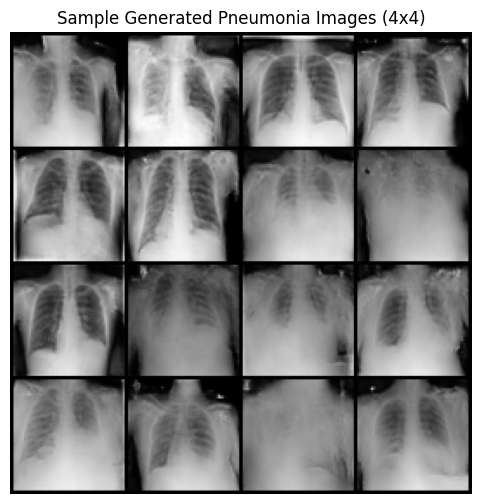

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

generator.load_state_dict(torch.load("best_rlrgenerator.pth", map_location=device))
generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    gen_labels = torch.ones(16, dtype=torch.long, device=device)  # Condition on pneumonia
    gen_imgs = generator(z, gen_labels)

# Convert images from [-1,1] to [0,1]
gen_imgs = (gen_imgs + 1) / 2
grid = make_grid(gen_imgs, nrow=4, padding=2, normalize=True)
np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))

plt.figure(figsize=(6, 6))
plt.imshow(np_grid)
plt.title("Sample Generated Pneumonia Images (4x4)")
plt.axis("off")
plt.show()


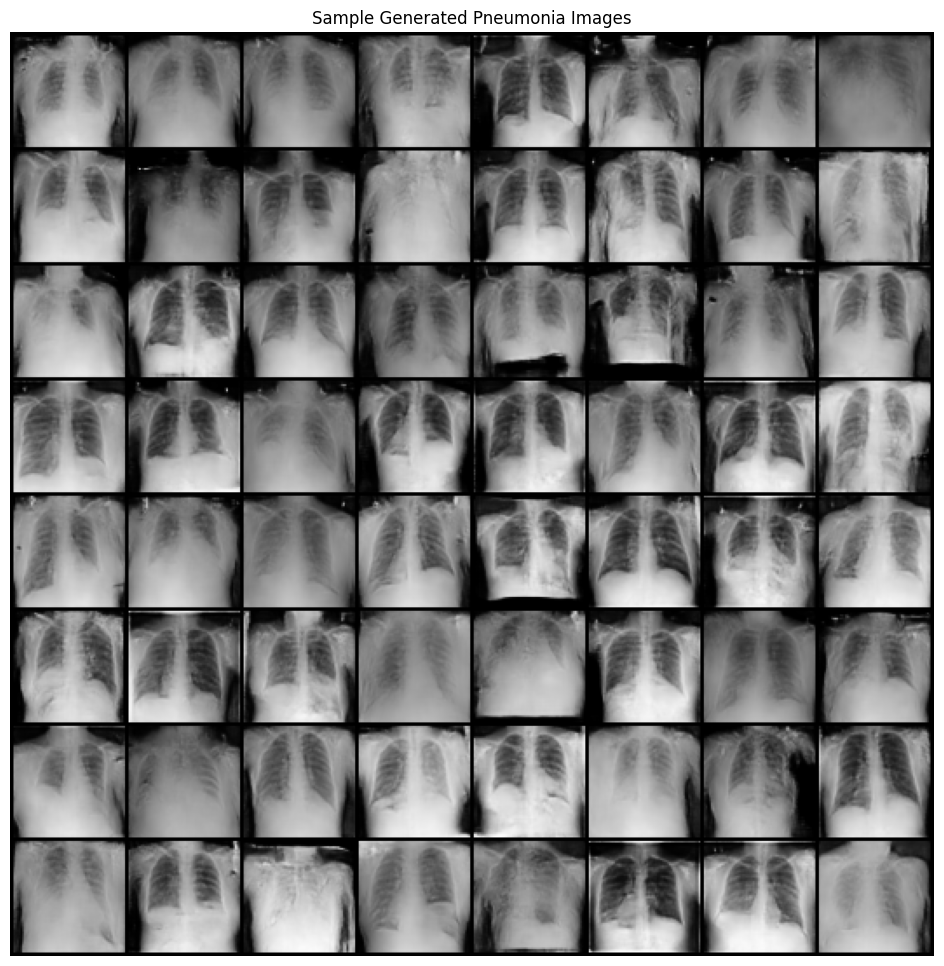

In [17]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

generator.load_state_dict(torch.load("best_rlrgenerator.pth", map_location=device))
generator.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen_labels = torch.ones(64, dtype=torch.long, device=device)  # Condition on pneumonia
    gen_imgs = generator(z, gen_labels)
    
# Convert images from [-1,1] to [0,1]
gen_imgs = (gen_imgs + 1) / 2
grid = make_grid(gen_imgs, nrow=8, padding=2, normalize=True)
np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))

plt.figure(figsize=(12, 12))
plt.imshow(np_grid)
plt.title("Sample Generated Pneumonia Images")
plt.axis("off")
plt.show()

In [20]:
import shutil
shutil.rmtree(temp_real_dir)
shutil.rmtree(temp_fake_dir)